In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [2]:
!pip install dill

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import warnings
from sklearn.exceptions import FitFailedWarning
import pickle

In [4]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Read preprocessed train data

In [5]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed')['target_event']

# Read and transform test data

In [6]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as file:
    test_pipeline = dill.load(file)

In [7]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

# Binary evaluation class

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

In [9]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

---
# ***Neural Network***
---

## Import libraries

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Create model class

In [11]:
class ChurnPredictionModel(nn.Module):
    def __init__(self, input_size, output_size, hidden=[64, 32, 16]):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden = hidden

        all_layers = []
        for i in range(len(hidden)):
            all_layers.append(nn.Linear(self.input_size, self.hidden[i]))
            all_layers.append(nn.BatchNorm1d(self.hidden[i]))
            all_layers.append(nn.ReLU())
            all_layers.append(nn.Dropout(0.2))
            self.input_size = self.hidden[i]

        all_layers.append(nn.Linear(self.input_size, self.output_size))
        all_layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        x = torch.tensor(x.values, dtype=torch.float32)
        pred = self.forward(x)
        return (pred > 0.5).float()

# Create object of NN model

In [12]:
model = ChurnPredictionModel(input_size=X_train.shape[1], output_size=1, hidden=[1024, 512, 128, 128, 64, 64, 32, 16])

In [13]:
model

ChurnPredictionModel(
  (model): Sequential(
    (0): Linear(in_features=63, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine

# Create train class

In [14]:
class TrainModel:
    def __init__(self, model, loss, optimizer, batch_size, epochs, tolerance=None, round=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.tolerance = tolerance
        self.round = round

        self.loss_hist_train = [0] * epochs
        self.f1_hist_train = [0] * epochs

        self.val_hist_f1 = [0] * epochs
        self.val_hist_loss = [0] * epochs

    def to_tensor(self, x, y):
        x = torch.tensor(x.values, dtype=torch.float32)
        y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        return x, y

    def data_loader(self, x, y):
        x_tensor, y_tensor = self.to_tensor(x, y)
        dataset = TensorDataset(x_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def early_stop(self, epoch):
        if len(self.val_hist_loss) < self.round + 1:
            return False

        trues = []
        for i in range(0, self.round):
            current_loss = self.val_hist_loss[epoch - i]
            previous_loss = self.val_hist_loss[epoch - i - 1]

            if abs(current_loss - previous_loss) < self.tolerance:
                trues.append(True)
            else:
                trues.append(False)

        if all(trues):
            print("Early stopping triggered.")
            return True

        return False

    def train_model(self, X_train, y_train, X_val, y_val):
        for epoch in range(self.epochs):
            self.model.train()
            train_dl = self.data_loader(X_train, y_train)
            epoch_loss = 0.0
            epoch_f1 = 0.0

            all_y_true = []
            all_y_pred = []

            for x_batch, y_batch in train_dl:
                y_pred = self.model(x_batch)
                loss = self.loss(y_pred, y_batch)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()

                y_pred_labels = (y_pred > 0.5).float()
                all_y_true.extend(y_batch.numpy().flatten())
                all_y_pred.extend(y_pred_labels.numpy().flatten())

            self.loss_hist_train[epoch] = epoch_loss / len(train_dl)
            # Calculate F1 score for the epoch
            epoch_f1 = f1_score(all_y_true, all_y_pred, average='binary')
            self.f1_hist_train[epoch] = epoch_f1  # Store F1 score

            if X_val is not None and y_val is not None:
                val_f1, val_loss = self.val_prediction(X_val, y_val)
                self.val_hist_f1[epoch] = val_f1  # Store validation F1 score
                self.val_hist_loss[epoch] = val_loss

            if self.tolerance is not None:
                if self.early_stop(epoch):
                    break

            print(f'Epoch {epoch + 1}/{self.epochs}, '
                  f'Loss: {self.loss_hist_train[epoch]:.4f}, '
                  f'F1 Score: {self.f1_hist_train[epoch]:.4f}')  # Changed to F1 Score

            if X_val is not None and y_val is not None:
                print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')
                print('======================================================')

        return self.loss_hist_train, self.f1_hist_train, self.val_hist_loss, self.val_hist_f1

    def val_prediction(self, X_val, y_val):
        X_val_tensor, y_val_tensor = self.to_tensor(X_val, y_val)
        with torch.no_grad():
            y_pred_raw = self.model(X_val_tensor)
            loss = self.loss(y_pred_raw, y_val_tensor)

            y_pred = (y_pred_raw > 0.5).float()

            f1 = f1_score(y_val_tensor.numpy(), y_pred.numpy(), average='binary')

            return f1, loss.item()

# Create hiperparameter tuning function for trying different learning rate

In [15]:
!pip install optuna

In [16]:
import optuna

In [17]:
learning_rate_grid = [0.001, 0.01, 0.015, 0.1]

best_val_f1 = 0.0

def objective(trial):
    global best_val_f1

    learning_rate = trial.suggest_categorical('learning_rate', learning_rate_grid)

    model = ChurnPredictionModel(input_size=X_train.shape[1], output_size=1, hidden=[128, 128, 64, 64, 32, 16])
    loss = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train = TrainModel(model, loss, optimizer, batch_size=32, epochs=30, tolerance=0.01, round=2)
    loss_hist_train, f1_hist_train, val_loss_hist, val_f1_hist = train.train_model(X_train, y_train, X_test, y_test)

    final_val_f1 = val_f1_hist[-1]

    if final_val_f1 > best_val_f1:
        best_val_f1 = final_val_f1
        torch.save(model.state_dict(), '/content/drive/MyDrive/Churn Prediction/best_model.pth')

    trial.set_user_attr('metrics', {
        'loss_hist_train': loss_hist_train,
        'f1_hist_train': f1_hist_train,
        'val_loss_hist': val_loss_hist,
        'val_f1_hist': val_f1_hist,
        'learning_rate': learning_rate
    })
    return final_val_f1

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)
print('Best hyperparameters:', study.best_params)

[I 2024-10-17 14:40:46,558] A new study created in memory with name: no-name-5efccc79-2665-4e17-8c23-f8eb50c43d57


Epoch 1/30, Loss: 0.4512, F1 Score: 0.7815
Validation Loss: 0.4595, Validation F1 Score: 0.7073
Epoch 2/30, Loss: 0.4338, F1 Score: 0.7912
Validation Loss: 0.4362, Validation F1 Score: 0.7318
Epoch 3/30, Loss: 0.4268, F1 Score: 0.7932
Validation Loss: 0.4168, Validation F1 Score: 0.7452
Epoch 4/30, Loss: 0.4205, F1 Score: 0.7971
Validation Loss: 0.4815, Validation F1 Score: 0.7283
Epoch 5/30, Loss: 0.4168, F1 Score: 0.8019
Validation Loss: 0.4234, Validation F1 Score: 0.7434
Epoch 6/30, Loss: 0.4141, F1 Score: 0.8022
Validation Loss: 0.4147, Validation F1 Score: 0.7411
Epoch 7/30, Loss: 0.4111, F1 Score: 0.8045
Validation Loss: 0.4283, Validation F1 Score: 0.7341
Epoch 8/30, Loss: 0.4090, F1 Score: 0.8054
Validation Loss: 0.4097, Validation F1 Score: 0.7464
Epoch 9/30, Loss: 0.4053, F1 Score: 0.8071
Validation Loss: 0.4287, Validation F1 Score: 0.7412
Epoch 10/30, Loss: 0.4051, F1 Score: 0.8073
Validation Loss: 0.4189, Validation F1 Score: 0.7360


[I 2024-10-17 14:45:26,696] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.01}. Best is trial 0 with value: 0.0.


Early stopping triggered.
Epoch 1/30, Loss: 0.4893, F1 Score: 0.7480
Validation Loss: 0.5177, Validation F1 Score: 0.7022
Epoch 2/30, Loss: 0.4686, F1 Score: 0.7638
Validation Loss: 0.4820, Validation F1 Score: 0.7176
Epoch 3/30, Loss: 0.4646, F1 Score: 0.7696
Validation Loss: 0.4619, Validation F1 Score: 0.7247
Epoch 4/30, Loss: 0.4569, F1 Score: 0.7730
Validation Loss: 0.4249, Validation F1 Score: 0.7262
Epoch 5/30, Loss: 0.4556, F1 Score: 0.7774
Validation Loss: 0.4489, Validation F1 Score: 0.7211
Epoch 6/30, Loss: 0.4525, F1 Score: 0.7783
Validation Loss: 0.4584, Validation F1 Score: 0.7355
Epoch 7/30, Loss: 0.4628, F1 Score: 0.7745
Validation Loss: 0.4263, Validation F1 Score: 0.7246
Epoch 8/30, Loss: 0.4604, F1 Score: 0.7750
Validation Loss: 0.4118, Validation F1 Score: 0.7074
Epoch 9/30, Loss: 0.4581, F1 Score: 0.7754
Validation Loss: 0.4537, Validation F1 Score: 0.7245
Epoch 10/30, Loss: 0.4543, F1 Score: 0.7757
Validation Loss: 0.4316, Validation F1 Score: 0.7240
Epoch 11/30, 

[I 2024-10-17 15:00:00,512] Trial 1 finished with value: 0.737684559127915 and parameters: {'learning_rate': 0.1}. Best is trial 1 with value: 0.737684559127915.


Epoch 30/30, Loss: 0.4478, F1 Score: 0.7833
Validation Loss: 0.4692, Validation F1 Score: 0.7377
Epoch 1/30, Loss: 0.4843, F1 Score: 0.7549
Validation Loss: 0.5612, Validation F1 Score: 0.7045
Epoch 2/30, Loss: 0.4706, F1 Score: 0.7638
Validation Loss: 0.5226, Validation F1 Score: 0.7030
Epoch 3/30, Loss: 0.4637, F1 Score: 0.7694
Validation Loss: 0.4548, Validation F1 Score: 0.7317
Epoch 4/30, Loss: 0.4579, F1 Score: 0.7720
Validation Loss: 0.4503, Validation F1 Score: 0.7373
Epoch 5/30, Loss: 0.4555, F1 Score: 0.7754
Validation Loss: 0.4675, Validation F1 Score: 0.7400
Epoch 6/30, Loss: 0.4545, F1 Score: 0.7768
Validation Loss: 0.4753, Validation F1 Score: 0.7350
Epoch 7/30, Loss: 0.4491, F1 Score: 0.7769
Validation Loss: 0.4210, Validation F1 Score: 0.7331
Epoch 8/30, Loss: 0.4493, F1 Score: 0.7784
Validation Loss: 0.5123, Validation F1 Score: 0.7232
Epoch 9/30, Loss: 0.4475, F1 Score: 0.7814
Validation Loss: 0.4058, Validation F1 Score: 0.7261
Epoch 10/30, Loss: 0.4483, F1 Score: 0.

[I 2024-10-17 15:14:39,725] Trial 2 finished with value: 0.7214225232853514 and parameters: {'learning_rate': 0.1}. Best is trial 1 with value: 0.737684559127915.


Early stopping triggered.
Epoch 1/30, Loss: 0.4505, F1 Score: 0.7801
Validation Loss: 0.4713, Validation F1 Score: 0.7177
Epoch 2/30, Loss: 0.4340, F1 Score: 0.7879
Validation Loss: 0.4715, Validation F1 Score: 0.7210
Epoch 3/30, Loss: 0.4278, F1 Score: 0.7939
Validation Loss: 0.4397, Validation F1 Score: 0.7325
Epoch 4/30, Loss: 0.4211, F1 Score: 0.7989
Validation Loss: 0.4219, Validation F1 Score: 0.7440
Epoch 5/30, Loss: 0.4179, F1 Score: 0.7981
Validation Loss: 0.4269, Validation F1 Score: 0.7487


[I 2024-10-17 15:17:03,346] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.01}. Best is trial 1 with value: 0.737684559127915.


Early stopping triggered.
Best hyperparameters: {'learning_rate': 0.1}


# Create new model with the weights of the best model in previous search

In [19]:
model = ChurnPredictionModel(input_size=X_train.shape[1], output_size=1, hidden=[128, 128, 64, 64, 32, 16])
best_weights = torch.load('/content/drive/MyDrive/Churn Prediction/best_model.pth', weights_only=True)
model.load_state_dict(best_weights)

<All keys matched successfully>

# Show loss curves of train and test data

In [20]:
best_trial = study.best_trial

In [21]:
train_loss = best_trial.user_attrs['metrics']['loss_hist_train']
train_f1 = best_trial.user_attrs['metrics']['f1_hist_train']

val_loss = best_trial.user_attrs['metrics']['val_loss_hist']
val_f1 = best_trial.user_attrs['metrics']['val_f1_hist']

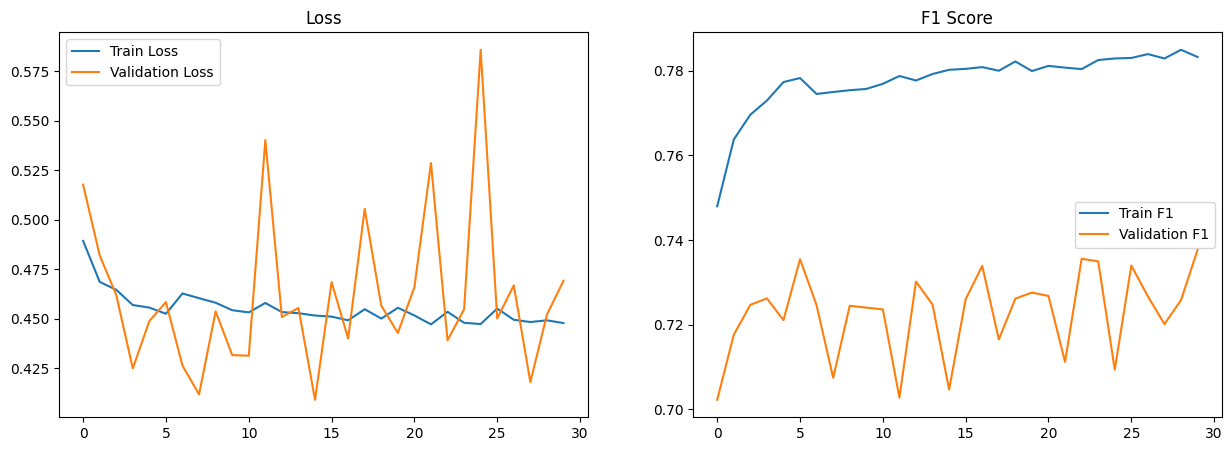

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()

ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(val_loss, label='Validation Loss')

ax[1].plot(train_f1, label='Train F1')
ax[1].plot(val_f1, label='Validation F1')

ax[0].set_title('Loss')
ax[1].set_title('F1 Score')

ax[0].legend()
ax[1].legend()

plt.show()

# Binary evaluation object

In [23]:
eval = BinaryClassificationEvaluation(y_test, model.predict(X_test), model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy())

# Evaluate model from different corner

In [24]:
print(eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     15296
           1       0.73      0.74      0.73      7226

    accuracy                           0.83     22522
   macro avg       0.80      0.80      0.80     22522
weighted avg       0.83      0.83      0.83     22522



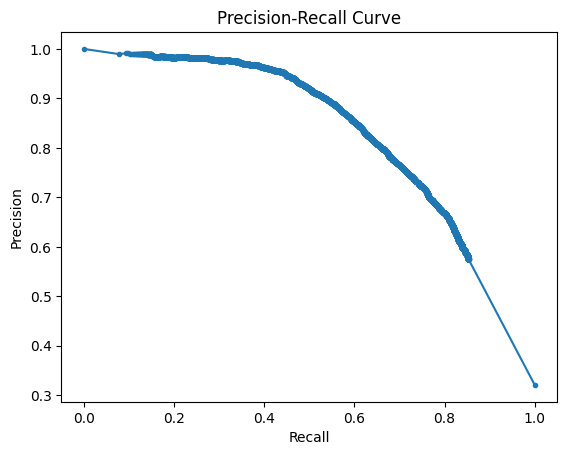

In [25]:
eval.precision_recall_curve_plot()

|| ROC AUC Score: 0.87 ||


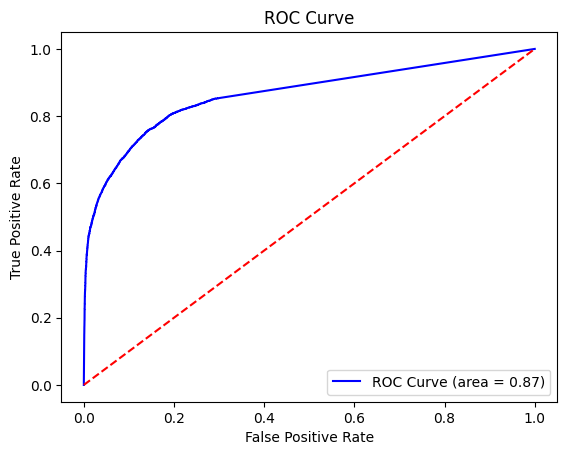

In [26]:
eval.roc_curve_visualization()

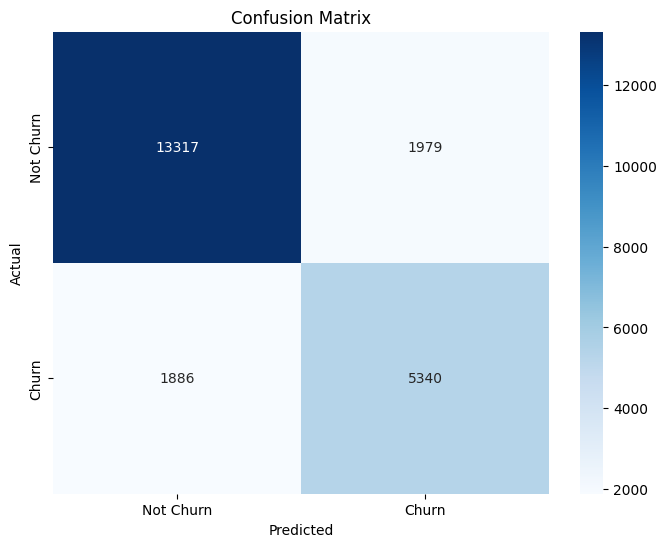

In [27]:
eval.visualize_confusion_matrix()

In [28]:
precision, recall, f1 = eval.precision_recall_f1()
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Precision: 0.7296, Recall: 0.7390, F1 Score: 0.7343


# Save the model

In [29]:
with open('/content/drive/MyDrive/Churn Prediction/NN_Churn.pkl', 'wb') as file:
    dill.dump(model, file)